In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE

# 1. Business Understanding
## Predicting customer churn so the company can implement better retention strategies.

# 2. Data Understanding




In [135]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Dataset shape:", df.shape)

Dataset shape: (7043, 21)


## Churn distribution

/tmp/ipython-input-3228197015.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set2')


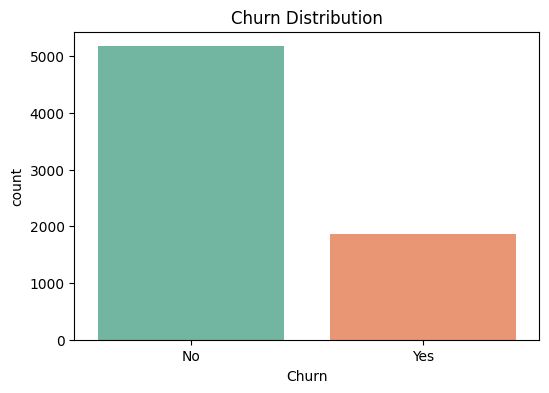

In [136]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title("Churn Distribution")
plt.show()

## Demographic analysis

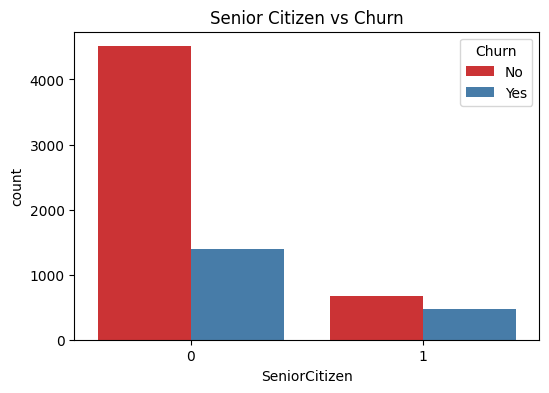

In [137]:
plt.figure(figsize=(6,4))
sns.countplot(x='SeniorCitizen', hue='Churn', data=df, palette='Set1')
plt.title("Senior Citizen vs Churn")
plt.show()

## Tenure analysis

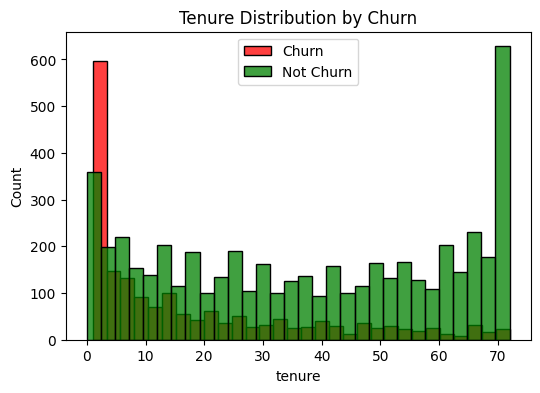

In [138]:
plt.figure(figsize=(6,4))
sns.histplot(df[df['Churn'] == 'Yes']['tenure'], bins=30, color='red', label='Churn')
sns.histplot(df[df['Churn'] == 'No']['tenure'], bins=30, color='green', label='Not Churn')
plt.legend()
plt.title("Tenure Distribution by Churn")
plt.show()

## Monthly charges analysis

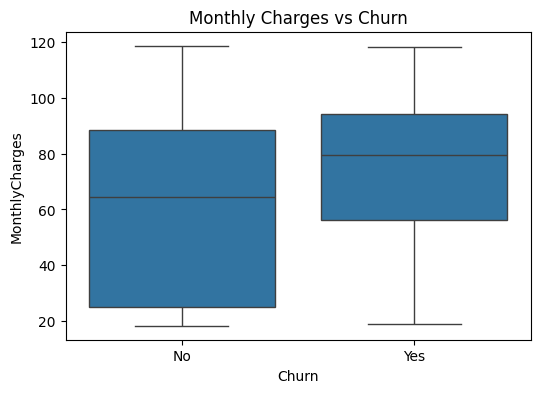

In [139]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()



# 3. Data Preparation

In [140]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipython-input-266577964.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


## Feature engineering: average charges per tenure

In [141]:
df['AvgChargesPerTenure'] = df['TotalCharges'] / (df['tenure'] + 1)

## Encode categorical variables

In [142]:
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn': # Exclude Churn for now as we need to encode it separately
        df[col] = le.fit_transform(df[col])

# Encode the target variable 'Churn'
df['Churn'] = le.fit_transform(df['Churn'])

## Train-test split

In [143]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [144]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure columns are aligned after one-hot encoding
X_train, X_test = X_train.align(X_test, join='inner', axis=1, fill_value=0)

# Now scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Scaling

In [145]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Modeling with Hyperparameter Tuning (XGBoost)

In [146]:
param_grid = {
'n_estimators': [200, 500],
'max_depth': [4, 6, 8],
'learning_rate': [0.01, 0.1, 0.2],
'subsample': [0.8, 1],
'colsample_bytree': [0.8, 1]
}

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_res, y_res)


print("Best Parameters:", grid.best_params_)
print("Best Training Accuracy:", grid.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:03:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Best Training Accuracy: 0.8353577575716189


## Evaluate on test set

In [147]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


print("===== XGBoost Tuned =====")
print(classification_report(y_test, y_pred))
print("Accuracy:", (y_pred == y_test).mean())
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))

===== XGBoost Tuned =====
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1035
           1       0.58      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.73      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409

Accuracy: 0.7842441447835344
ROC-AUC: 0.8394120230437366


# 5. Evaluation - Confusion Matrix & ROC Curve

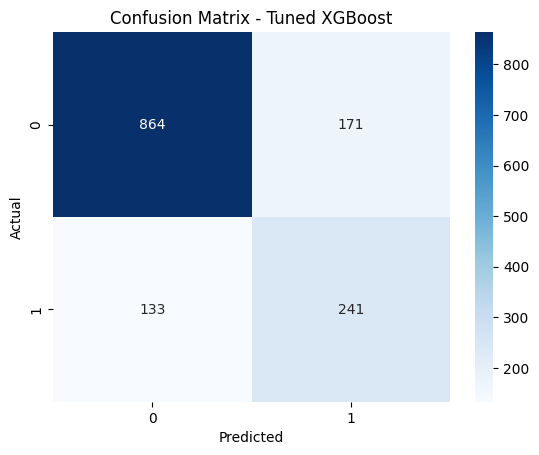

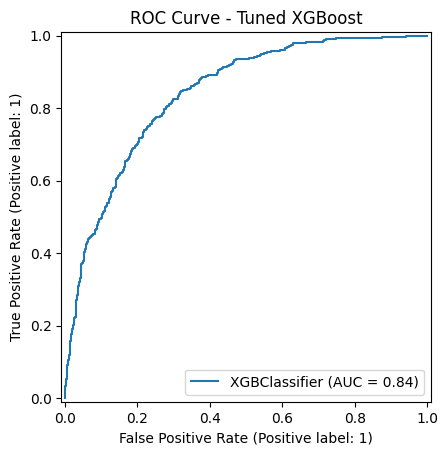

In [148]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned XGBoost")
plt.show()


RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Tuned XGBoost")
plt.show()

# 6. Deployment / Business Insight

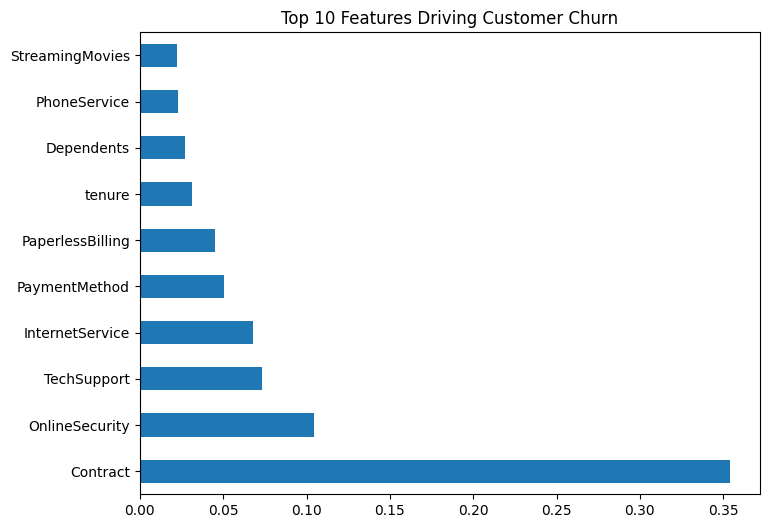


Business Insight:
- High Monthly Charges, short Tenure, and the absence of Online Security are the main churn drivers.
- Senior Citizens without a partner also show a higher tendency to churn.

Recommendations:
1. Offer discounts or bundling packages for customers with high MonthlyCharges.
2. Provide loyalty rewards for new customers with low tenure.
3. Promote Online Security features to help reduce churn.


In [149]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', figsize=(8,6))
plt.title("Top 10 Features Driving Customer Churn")
plt.show()


print("\nBusiness Insight:")
print("- High Monthly Charges, short Tenure, and the absence of Online Security are the main churn drivers.")
print("- Senior Citizens without a partner also show a higher tendency to churn.")


print("\nRecommendations:")
print("1. Offer discounts or bundling packages for customers with high MonthlyCharges.")
print("2. Provide loyalty rewards for new customers with low tenure.")
print("3. Promote Online Security features to help reduce churn.")